# Entropy ANOVA + Plots

In [3]:
!pip install -q pycountry langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.stats as stats
import re
import nltk
from nltk.corpus import words
from collections import Counter
import math
import unicodedata
import time
from tqdm import tqdm
import pickle
from langdetect import detect
import warnings
import pycountry
from scipy import stats

In [9]:
# Import data from custom dataset
original_df = pd.read_pickle('/kaggle/input/reviews-analyzer-dataset/df_w_langs_entropies.pkl')
original_df.rename(columns={'language': 'lang_code'}, inplace=True)
original_df.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,entropy,lang_code
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,"Mar 18, 2017",1,4.262386,en
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,"Nov 09, 2015",1,4.081944,en


Get the actual names of all the languages and add a new column

In [10]:
def get_language_name(code):
    """Convert ISO 639-1 code to full language name using pycountry."""
    if code == 'unknown':
        return 'Unknown'
    try:
        # Handle cases like 'zh-cn' by taking the first part
        code = code.split('-')[0]
        lang = pycountry.languages.get(alpha_2=code)
        return lang.name if lang else code
    except AttributeError:
        return code

In [12]:
original_df['language'] = original_df['lang_code'].apply(get_language_name)
original_df.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,entropy,lang_code,language
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,"Mar 18, 2017",1,4.262386,en,English
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,"Nov 09, 2015",1,4.081944,en,English


In [45]:
#lang_counts_df.iloc[i,1]/lang_counts_df.count.sum()
lang_counts_df['count']/lang_counts_df['count'].sum()

0     8.183447e-01
1     6.761549e-02
2     2.269317e-02
3     1.362882e-02
4     1.096438e-02
5     1.077190e-02
6     1.066604e-02
7     8.684199e-03
8     4.950812e-03
9     4.353442e-03
10    4.333507e-03
11    2.898858e-03
12    2.494654e-03
13    2.295989e-03
14    2.185314e-03
15    1.525389e-03
16    1.417464e-03
17    1.404403e-03
18    1.022884e-03
19    1.020134e-03
20    9.768263e-04
21    9.321439e-04
22    7.747243e-04
23    6.441142e-04
24    5.011305e-04
25    3.602090e-04
26    3.375241e-04
27    2.997159e-04
28    2.880297e-04
29    2.660322e-04
30    2.550335e-04
31    2.392228e-04
32    2.179127e-04
33    1.168617e-04
34    1.010510e-04
35    9.073967e-05
36    7.286671e-05
37    7.011702e-05
38    6.186796e-05
39    5.155663e-05
40    2.405976e-05
41    1.649812e-05
42    1.374844e-05
43    6.874218e-06
44    2.749687e-06
45    2.062265e-06
46    2.062265e-06
47    2.062265e-06
48    6.874218e-07
Name: count, dtype: float64

Top 10 Languages % of Total
| Language | Pct of Total |
|--|--|
|English|81.83%|
|Spanish|6.76%|
|French|2.27%|
|Somali|1.36%|
|Romanian|1.10%|
|Portuguese|1.08%|
|Catalan|1.07%|
|Afrikaans|0.87%|
|Unknown|0.50%|
|Russian|0.44%|



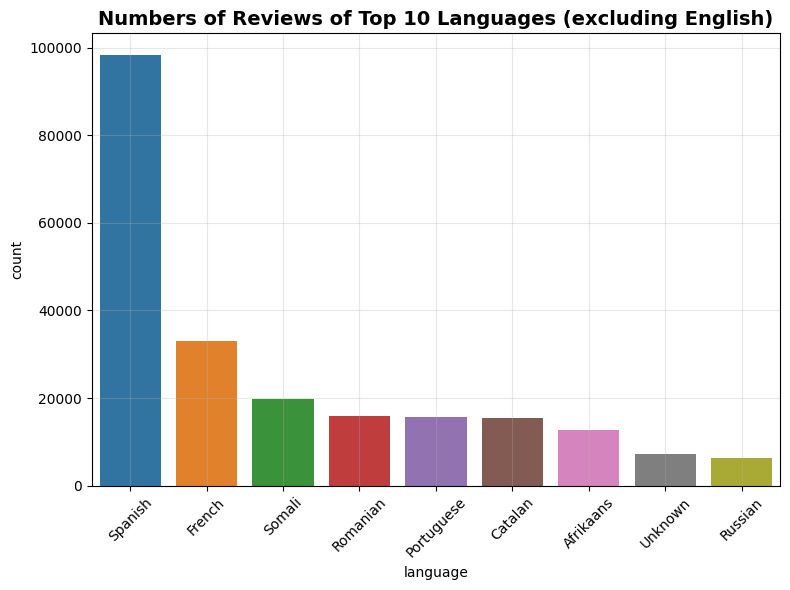

In [48]:
# Plot the counts of the top 10 languages
def count_and_plot_languages(df, top=10):
    
    lang_counts_df = df.language.value_counts().reset_index()
    n = lang_counts_df['count'].sum()
    # Make markdown chart
    table = f'| Language | Pct of Total |\n'
    table += f'|--|--|\n'
    for i in range(10):
        table += f'|{lang_counts_df.iloc[i,0]}|{lang_counts_df.iloc[i,1]/n:.2%}|\n'
    print("Top 10 Languages % of Total")
    print(table)
    
    plt.figure(figsize=(8,6))
    sns.barplot(x='language', y='count', data=lang_counts_df.iloc[1:10])
    plt.title('Numbers of Reviews of Top 10 Languages (excluding English)', fontweight='bold', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('review_lang_dist.png')
    plt.show()

count_and_plot_languages(original_df, 10)

In [19]:
lang_counts_df.iloc[0:10,:]

,language,count
0,English,1190455
1,Spanish,98361
2,French,33012
3,Somali,19826
4,Romanian,15950
5,Portuguese,15670
6,Catalan,15516
7,Afrikaans,12633
8,Unknown,7202
9,Russian,6333


Next identify the outlier language counts and exclude those.

#### Check assumptions
- Use Shapiro Wilk test for normality https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test
- Use Levene's test for equal variances
- Also check QQ plots

In [ ]:
def check_assumptions():
    # Check normality (Shapiro-Wilk test) and print in markdown table
    print("\nNormality Test (Shapiro-Wilk):")
    normality_table = '| Language | p-value |\n'
    normality_table += '|--|--|\n'
    for lang, entropy_group in zip(valid_languages, grouped_entropies):
        if len(entropy_group) > 3:  # Shapiro needs > 3 samples
            stat, p = stats.shapiro(entropy_group)
            normality_table += f"|{lang} | p-value = {p:.4f} {'(not normal)' if p < 0.05 else '(normal)'}|\n"
    print(normality_table)
    
    # Check equal variances (Levene's test)
    stat, p = stats.levene(*grouped_entropies)
    print(f"\nLevene's Test for Equal Variances: p-value = {p:.4f} {'(unequal)' if p < 0.05 else '(equal)'}")
    

In [ ]:
def plot_qq_by_language(df, review_col='reviews'):
    """Generate Q-Q plots for entropy distributions by language."""
    
    # Filter languages with enough samples (e.g., >= 5 for meaningful plots)
    language_counts = df['language'].value_counts()
    valid_languages = language_counts[language_counts >= 5].index
    df_filtered = df[df['language'].isin(valid_languages)].copy()
    
    if len(valid_languages) == 0:
        print("No languages with 5+ reviews for Q-Q plots.")
        return
    
    # Plot Q-Q for each language
    for lang in valid_languages:
        entropy_data = df_filtered[df_filtered['language'] == lang]['entropy']
        print(f"\n{lang} Entropy Stats (N = {len(entropy_data)}):")
        print(entropy_data.describe())
        
        plt.figure(figsize=(8, 6))
        stats.probplot(entropy_data, dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of Entropy for {lang} Reviews (N = {len(entropy_data)})')
        plt.grid(True, alpha=0.3)
        plt.show()

plot_qq_by_language(sample_df)

In [ ]:
# FUnction to statistically detect differences in entropy of languages
def test_entropy_differences(df, review_col='review_comment'):
    """Test for significant differences in entropy across languages.
       Feed this a df with entropies calculated/languages tagged for faster runtime"""
    # Check if entropy/language tags are there
    if 'entropy' not in df.columns:
        df['entropy'] = df[review_col].apply(calculate_entropy)
    if 'language' not in df.columns:
        df['language'] = df[review_col].apply(detect_language)
    
    # Filter out 'unknown' and languages with too few samples (< 2)
    language_counts = df['language'].value_counts()
    valid_languages = language_counts[language_counts >= 2].index
    df_filtered = df[df['language'].isin(valid_languages)].copy()
    
    if len(valid_languages) < 2:
        print("Not enough languages with sufficient samples (>= 2 reviews) for comparison.")
        return
    
    # Group entropies by language
    grouped_entropies = [df_filtered[df_filtered['language'] == lang]['entropy'].values 
                         for lang in valid_languages]
    
    # Print summary stats in markdown table
    print("Entropy Means by Language:")
    entropy_table = '| Language | Mean | Std Dev | N |\n'
    entropy_table += '|---|---|---|---|\n'
    for lang, group in df_filtered.groupby('language'):
        entropy_table += f"| {lang} | Mean = {group['entropy'].mean():.2f} | Std = {group['entropy'].std():.2f}| N = {len(group)}|\n" 
    print(entropy_table)

    # Check normality (Shapiro-Wilk test) and print in markdown table
    print("\nNormality Test (Shapiro-Wilk):")
    normality_table = '| Language | p-value |\n'
    normality_table += '|--|--|\n'
    for lang, entropy_group in zip(valid_languages, grouped_entropies):
        if len(entropy_group) > 3:  # Shapiro needs > 3 samples
            stat, p = stats.shapiro(entropy_group)
            normality_table += f"|{lang} | p-value = {p:.4f} {'(not normal)' if p < 0.05 else '(normal)'}|\n"
    print(normality_table)
    
    # Check equal variances (Levene's test)
    stat, p = stats.levene(*grouped_entropies)
    print(f"\nLevene's Test for Equal Variances: p-value = {p:.4f} {'(unequal)' if p < 0.05 else '(equal)'}")
    
    # ANOVA (if assumptions hold)
    if all(stats.shapiro(group)[1] >= 0.05 for group in grouped_entropies if len(group) > 3) and p >= 0.05:
        f_stat, p_anova = stats.f_oneway(*grouped_entropies)
        print(f"\nANOVA: F = {f_stat:.2f}, p-value = {p_anova:.4f}")
        if p_anova < 0.05:
            print("Significant difference detected (ANOVA).")
            # Post-hoc: Tukey's HSD
            tukey = pairwise_tukeyhsd(endog=df_filtered['entropy'], 
                                    groups=df_filtered['language'], 
                                    alpha=0.05)
            print(tukey)
    else:
        # Kruskal-Wallis (non-parametric)
        h_stat, p_kruskal = stats.kruskal(*grouped_entropies)
        print(f"\nKruskal-Wallis: H = {h_stat:.2f}, p-value = {p_kruskal:.4f}")
        if p_kruskal < 0.05:
            print("Significant difference detected (Kruskal-Wallis).")
            # Post-hoc: Pairwise Mann-Whitney U (optional)
            from itertools import combinations
            print("\nPairwise Mann-Whitney U Tests (Bonferroni corrected):")
            pairs = list(combinations(valid_languages, 2))
            alpha_corrected = 0.05 / len(pairs)
            for lang1, lang2 in pairs:
                u_stat, p = stats.mannwhitneyu(
                    df_filtered[df_filtered['language'] == lang1]['entropy'],
                    df_filtered[df_filtered['language'] == lang2]['entropy'],
                    alternative='two-sided'
                )
                print(f"{lang1} vs {lang2}: p-value = {p:.4f} {'(significant)' if p < alpha_corrected else ''}")
